<a href="https://colab.research.google.com/github/lifepopkay/Tech-Monies/blob/Modelling/Final_Models_using_Lasso_(For_NIG%2C_UK%2C_IND%2C_and_US).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the required libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_B = pd.read_csv("Mergered Cleaned Data (1).csv")
df_C = pd.read_csv("Mergered Cleaned Data 3.csv")

In [ ]:
print(df_B.shape)
df_B.head(2)

(9709, 18)


,Unnamed: 0,id,company,location,postDate,title scraped for,Country,upper_salary,lower_salary,payment_frequency,State,age,Position,year_of_exp,contract_type,eligibility,title_cleaned,skills_list
0,0,job_3e1d31dda6c5cb4b,Offerzen,Lagos,Just posted,Data Scientist,Nigeria,NaN,NaN,NaN,Lagos,NaN,Senior Level,2.0,Full-time,NaN,Senior Software Engineer,"['AWS', 'D', 'C', 'asp', 'R']"
1,1,job_c3e2ed6ba483528b,GVA Partners,Lagos,Today,Data Scientist,Nigeria,NaN,NaN,NaN,Lagos,NaN,NaN,4.0,NaN,undergraduate,Data Scientist,"['D', 'C', 'R', 'KNN', 'asp', 'PL/SQL', 'serve..."


In [ ]:
print(df_C.shape)
df_C.head(2)

(18426, 17)


,id,company,location,postDate,title scraped for,Country,State,age,Position,upper_salary,lower_salary,payment_frequency,year_of_exp,contract_type,eligibility,title_cleaned,skills_list
0,job_3e1d31dda6c5cb4b,Offerzen,Lagos,Just posted,Data Scientist,Nigeria,Lagos,NaN,Senior Level,NaN,NaN,NaN,2.0,Full-time,NaN,Senior Software Engineer,"['asp', 'C', 'R', 'D', 'AWS']"
1,job_c3e2ed6ba483528b,GVA Partners,Lagos,Today,Data Scientist,Nigeria,Lagos,NaN,NaN,NaN,NaN,NaN,4.0,NaN,undergraduate,Data Scientist,"['Regression', 'C', 'KNN', 'Python', 'D', 'asp..."


In [ ]:
df = pd.concat([df_B, df_C], ignore_index=True)

In [ ]:
#url = 'https://raw.githubusercontent.com/lifepopkay/Tech-Monies/Modelling/Cleaned%20Data.csv'
#df = pd.read_csv("Mergered Cleaned Data.csv")

In [ ]:
df.head(2)

,Unnamed: 0,id,company,location,postDate,title scraped for,Country,upper_salary,lower_salary,payment_frequency,State,age,Position,year_of_exp,contract_type,eligibility,title_cleaned,skills_list
0,0.0,job_3e1d31dda6c5cb4b,Offerzen,Lagos,Just posted,Data Scientist,Nigeria,NaN,NaN,NaN,Lagos,NaN,Senior Level,2.0,Full-time,NaN,Senior Software Engineer,"['AWS', 'D', 'C', 'asp', 'R']"
1,1.0,job_c3e2ed6ba483528b,GVA Partners,Lagos,Today,Data Scientist,Nigeria,NaN,NaN,NaN,Lagos,NaN,NaN,4.0,NaN,undergraduate,Data Scientist,"['D', 'C', 'R', 'KNN', 'asp', 'PL/SQL', 'serve..."


In [ ]:
# Standardizing the title 
ML=['Machine Learning', 'Machine Learning ']
for title in ML:
    df['title scraped for'].replace(title,'Machine Learning Engineer', inplace = True)

In [ ]:
# Dropping records with missing values for lower salary range
df.dropna(subset=["lower_salary"], inplace = True)

In [ ]:
df.shape

(11361, 18)

In [ ]:
#df.drop_duplicates(subset = "id", inplace = True, ignore_index = True)

In [ ]:
# Columns to drop
columns_to_drop = ["company", "location", "State", "age", "Unnamed: 0", "id","postDate"]

In [ ]:
# Dropping records for canada
df = df.query("Country != 'Canada'")
# Dropping records for data engineering
df = df[df["title scraped for"] != "Data Engineer"]

# Drop unnecessary columns
df.drop(columns_to_drop, axis="columns", inplace = True)

In [ ]:
df.Country.value_counts()

USA        4466
UK         3115
India      1832
Nigeria     188
Name: Country, dtype: int64

In [ ]:
# Defining a function that replaces all values o years of eperience greater than 30 with np.nan
def yoe_greater_than_30(yoe):
    if yoe > 30:
        return np.nan
    else:
        return yoe
df.year_of_exp = df.year_of_exp.apply(yoe_greater_than_30)

In [ ]:
# Replace "hs" with "high school diploma" in eligibility
df.eligibility.replace("hs",'high school diploma', inplace = True)

# Fill missing values for eligibility with "high school diploma"
df.eligibility.fillna('high school diploma', inplace = True)

In [ ]:
# Fill missing values for contract_type with the mode of contract_type
df.contract_type.fillna(df.contract_type.mode()[0], inplace = True)

In [ ]:
# Creating an exchange rate for each country currency with respect to UD dollars
Exchange_rate = {"Nigeria": 427.88,
"India": 79.97,
"USA": 1,
"UK": 1.17}
df["Exchange_rate"] = df.Country.map(Exchange_rate)

# Converting the salary currency for each Job to US dollars
df.upper_salary = df.upper_salary / df.Exchange_rate
df.lower_salary = df.lower_salary / df.Exchange_rate

df.drop('Exchange_rate', axis= "columns", inplace = True)

On exploring the salary for missing Payment frequency, it was discovered that the salary far exceeds the salary for hourly payment frequency and is far below the salary for minthly payment frequency. 

So the the missing values for payment frequency will be filled with "Weekly"

In [ ]:
# Filling the missing values for payment frequency with "Weekly"
df.payment_frequency.fillna("Weekly", inplace = True)

In [ ]:
# Defining a function that cleans the skills column
def convert_skill_list_to_list(skills):
    skills = skills.replace("[", "")
    skills = skills.replace("]","")
    skills = skills.replace("'", "")
    Skills_list = skills.split(",")
    Skills_lists = []
    for skill in Skills_list:
        skill = skill.strip()
        Skills_lists.append(skill)
    return Skills_lists

In [ ]:
#convert_skill_list_to_list(df.skills_list)

In [ ]:
df.skills_list = df.skills_list.apply(convert_skill_list_to_list)

In [ ]:
# Defining a function that counts the number of job posting that require a particular skill
def Skills_table(df):
    list_skill = {}
    for Skill_list in df.skills_list:
        for Skill in Skill_list:
            if Skill in list_skill:
                list_skill[Skill] += 1
            else:
                list_skill[Skill] = 1
    skill_df = pd.DataFrame(list_skill, index = ["Number of jobs"]).T.sort_values("Number of jobs", ascending = False)
    return skill_df

In [ ]:
# Selecting the Job postings for data analyst roles
DA_df = df[df["title scraped for"] == "Data Analyst"]

# Selecting the Job postings for data scientist roles
DS_df = df[df["title scraped for"] == "Data Scientist"]

# Selecting the Job postings for business analyst roles
BA_df = df[df["title scraped for"] == "Business Analyst"]

# Selecting the Job postings for machine learning engineering roles
ML_df = df[df["title scraped for"] == "Machine Learning Engineer"]

# Selecting the Job postings for web developer roles
WD_df = df[df["title scraped for"] == "Web Developer"]

In [ ]:
# Selecting the Skills required for Data analyst roles
DASkills_df = Skills_table(DA_df)

# Saving the top 10 skills for Data Analyst to a list
DAT10_skills = list(DASkills_df.head(10).index)

# Selecting the Skills required for Data scientist roles
DSSkills_df = Skills_table(DS_df)

# Saving the top 10 skills for Data Scientist to a list
DST10_skills = list(DSSkills_df.head(10).index)

# Selecting the Skills required for Business analyst roles
BASkills_df = Skills_table(BA_df)

# Saving the top 10 skills for Business Analyst to a list
BAT10_skills = list(BASkills_df.head(10).index)

# Selecting the Skills required for Machine learning roles
MLSkills_df = Skills_table(ML_df)

# Saving the top 10 skills for Machine learning to a list
MLT10_skills = list(MLSkills_df.head(10).index)

# Selecting the Skills required for Web developer roles
WDSkills_df = Skills_table(WD_df)

# Saving the top 10 skills for Web developer to a list
WDT10_skills = list(WDSkills_df.head(10).index)

# Merging the top 10 skills for each role into a set
Most_popular_skills = set(DAT10_skills + DST10_skills + BAT10_skills + MLT10_skills + WDT10_skills)

len(list(Most_popular_skills))

23

In [ ]:
# Dropping records with missing values for lower salary range
#df.dropna(subset=["lower_salary"], inplace = True)

In [ ]:
df.Country.value_counts()

USA        4466
UK         3115
India      1832
Nigeria     188
Name: Country, dtype: int64

In [ ]:
df_NIG = df.query("Country == 'Nigeria'")
df_NIG = df_NIG.sample(5000, replace = True, random_state = 243)
df_IND = df.query("Country == 'India'")
df_IND = df_IND.sample(5000, replace = True, random_state = 243)
df_UK = df.query("Country == 'UK'")
df_UK = df_UK.sample(5000, replace = True, random_state = 243)
df_US = df.query("Country == 'USA'")
df_US = df_US.sample(5000, replace = True, random_state = 243)
df = pd.concat([df_IND, df_NIG,df_UK, df_US ], ignore_index=True)

In [ ]:
# Dropping missing values for title scraped for
df.dropna(subset = ["title scraped for"], inplace = True)

In [ ]:
# Determining the average years of experience for each role and position
df.groupby(["Country","title scraped for","Position"])[["year_of_exp"]].agg(np.mean)

year_of_exp
Country title scraped for         Position                 
India   Business Analyst          Mid-Level        2.000000
                                  Senior Level     4.760000
        Data Analyst              Senior Level     2.500000
        Data Scientist            Mid-Level        1.363636
                                  Senior Level     1.770492
        Machine Learning Engineer Mid-Level        1.960000
                                  Senior Level     2.952381
        Web Developer             Mid-Level        1.804348
                                  Senior Level     2.498084
Nigeria Business Analyst          Senior Level     4.782178
        Data Analyst              Senior Level     5.517241
        Data Scientist            Senior Level     6.000000
        Machine Learning Engineer Mid-Level        5.000000
                                  Senior Level     1.000000
        Web Developer             Mid-Level        2.840708
                                  Senior Level     4.513274
UK      Business Analyst          Mid-Level        3.000000
                                  Senior Level     3.000000
        Data Analyst              Senior Level          NaN
        Data Scientist            Entry Level           NaN
                                  Mid-Level        2.714286
                                  Senior Level     4.709821
        Machine Learning Engineer Mid-Level        9.000000
                                  Senior Level     9.000000
        Web Developer             Mid-Level        2.195122
                                  Senior Level     4.011765
USA     Business Analyst          Entry Level      1.000000
                                  Mid-Level        3.444444
                                  Senior Level     4.356725
        Data Analyst              Entry Level      1.000000
                                  Mid-Level        3.500000
                                  Senior Level     3.963855
        Data Scientist            Entry Level      1.000000
                                  Mid-Level        4.125000
                                  Senior Level     3.460055
        Machine Learning Engineer Entry Level      3.800000
                                  Mid-Level        2.950000
                                  Senior Level     4.760870
        Web Developer             Entry Level      5.000000
                                  Mid-Level        4.875000
                                  Senior Level     4.254902

In [ ]:
# Defining a function that determines the Position based on years of expereience
def Position_based_on_yoe(data):
    data.reset_index(drop=True, inplace = True)
    for i in range(data.shape[0]):
        if  data.loc[i,"Position"] is np.nan:
            if data.loc[i,"title scraped for"] == 'Business Analyst':
                if  data.loc[i,"year_of_exp"] >= 3 and data.loc[i,"year_of_exp"] <= 5:
                        data.loc[i,"Position"] = "Mid-Level"
                elif data.loc[i,"year_of_exp"] > 5:
                        data.loc[i,"Position"] = "Senior Level"
                elif data.loc[i,"year_of_exp"] < 3:
                    data.loc[i,"Position"] = "Entry Level"

            elif data.loc[i,"title scraped for"] == 'Data Analyst':
                if  data.loc[i,"year_of_exp"] > 2 and data.loc[i,"year_of_exp"] <= 4:
                        data.loc[i,"Position"] = "Mid-Level"
                elif data.loc[i,"year_of_exp"] > 4:
                        data.loc[i,"Position"] = "Senior Level"
                elif data.loc[i,"year_of_exp"] <= 2:
                    data.loc[i,"Position"] = "Entry Level"

            elif data.loc[i,"title scraped for"]== 'Data Scientist':
                if  data.loc[i,"year_of_exp"] > 2 and data.loc[i,"year_of_exp"] <= 4:
                        data.loc[i,"Position"] = "Mid-Level"
                elif data.loc[i,"year_of_exp"] > 4:
                        data.loc[i,"Position"] = "Senior Level"
                elif data.loc[i,"year_of_exp"] <= 2:
                    data.loc[i,"Position"] = "Entry Level"
            elif data.loc[i,"title scraped for"] == 'Machine Learning Engineer':
                if  data.loc[i,"year_of_exp"] > 3 and data.loc[i,"year_of_exp"] <= 5:
                        data.loc[i,"Position"] = "Mid-Level"
                elif data.loc[i,"year_of_exp"] > 5:
                        data.loc[i,"Position"] = "Senior Level"
                elif data.loc[i,"year_of_exp"] <= 3:
                    data.loc[i,"Position"] = "Entry Level"

            elif data.loc[i,"title scraped for"] == 'Web Developer':
                if  data.loc[i,"year_of_exp"] >= 2 and data.loc[i,"year_of_exp"] <= 4:
                        data.loc[i,"Position"] = "Mid-Level"
                elif data.loc[i,"year_of_exp"] > 4:
                        data.loc[i,"Position"] = "Senior Level"
                elif data.loc[i,"year_of_exp"] < 2:
                    data.loc[i,"Position"] = "Entry Level"
        
        else:
            data.loc[i,"Position"] = data.loc[i,"Position"]
    return data

In [ ]:
# Making a copy of the data 
data = df.copy()

# Determining the position using the Position_based_on_yoe function
df = Position_based_on_yoe(data)

In [ ]:
# Defining a function that counts the number of recors we have for each level for each role for each country
def number_of_observations(data):
    return data.groupby(["Country","title scraped for","Position"]).agg({"Position":"count"})

number_of_observations(df)

Position
Country title scraped for         Position              
India   Business Analyst          Entry Level        211
                                  Mid-Level          118
                                  Senior Level        46
        Data Analyst              Entry Level        205
                                  Mid-Level           49
                                  Senior Level        82
        Data Scientist            Entry Level        323
                                  Mid-Level          109
                                  Senior Level       181
        Machine Learning Engineer Entry Level        354
                                  Mid-Level          146
                                  Senior Level       180
        Web Developer             Entry Level       1053
                                  Mid-Level          681
                                  Senior Level       352
Nigeria Business Analyst          Entry Level         96
                                  Mid-Level          800
                                  Senior Level       202
        Data Analyst              Entry Level         63
                                  Mid-Level          437
                                  Senior Level       323
        Data Scientist            Mid-Level           49
                                  Senior Level       117
        Machine Learning Engineer Mid-Level           98
                                  Senior Level       157
        Web Developer             Entry Level        269
                                  Mid-Level          749
                                  Senior Level       312
UK      Business Analyst          Mid-Level          595
                                  Senior Level       105
        Data Analyst              Senior Level       744
        Data Scientist            Entry Level        105
                                  Mid-Level          103
                                  Senior Level       930
        Machine Learning Engineer Mid-Level            5
                                  Senior Level       517
        Web Developer             Entry Level         60
                                  Mid-Level          314
                                  Senior Level       464
USA     Business Analyst          Entry Level        149
                                  Mid-Level          765
                                  Senior Level       253
        Data Analyst              Entry Level        123
                                  Mid-Level          107
                                  Senior Level       176
        Data Scientist            Entry Level        123
                                  Mid-Level          495
                                  Senior Level       488
        Machine Learning Engineer Entry Level        229
                                  Mid-Level          123
                                  Senior Level       317
        Web Developer             Entry Level         62
                                  Mid-Level          148
                                  Senior Level       208

In [ ]:
Frequency_to_yearly = {"Hourly": 40 * 52,
"Weekly": 52,
"Monthly": 12,
"Yearly": 1}
df["Frequency_to_yearly"] = df.payment_frequency.map(Frequency_to_yearly)

# Standardizing the payment frequency to Yearly
df.upper_salary = df.upper_salary * df["Frequency_to_yearly"]
df.lower_salary = df.lower_salary * df["Frequency_to_yearly"]
df.drop('Frequency_to_yearly', axis= "columns", inplace = True)

In [ ]:
# Drop unecessary columns
df.drop(['title_cleaned','payment_frequency'], axis="columns", inplace = True)

In [ ]:
# Determining the average upper and lower salary for each level for each title for each country
df.groupby(["Country", "title scraped for", "Position"])[["lower_salary","upper_salary"]].agg(np.mean)

lower_salary   upper_salary
Country title scraped for         Position                                  
India   Business Analyst          Entry Level     4152.825556    7088.505746
                                  Mid-Level       8281.556219   17298.420146
                                  Senior Level   13955.581169   21205.212824
        Data Analyst              Entry Level     4123.992839    7217.712559
                                  Mid-Level       5259.149477   10637.037500
                                  Senior Level   14340.536238   24306.752713
        Data Scientist            Entry Level     7237.743101   14224.016135
                                  Mid-Level       7637.668483   16571.914081
                                  Senior Level   15876.119291   28230.524123
        Machine Learning Engineer Entry Level    10526.540285   13081.811195
                                  Mid-Level      12648.772399   20257.868576
                                  Senior Level   15724.952413   28464.377845
        Web Developer             Entry Level     3172.064785    6399.122455
                                  Mid-Level       6856.933667   10154.705336
                                  Senior Level    7872.054933   13666.589933
Nigeria Business Analyst          Entry Level     3374.193699            NaN
                                  Mid-Level       7807.971861   12614.717942
                                  Senior Level   15362.408448   12620.360849
        Data Analyst              Entry Level     2804.524633            NaN
                                  Mid-Level       6408.820112    7957.526570
                                  Senior Level   10071.977010   19499.694802
        Data Scientist            Mid-Level      19631.672432            NaN
                                  Senior Level    5609.049266            NaN
        Machine Learning Engineer Mid-Level       4149.551753            NaN
                                  Senior Level    4322.897842    7486.654741
        Web Developer             Entry Level     2814.429088    5291.555911
                                  Mid-Level       6496.462268    7841.311085
                                  Senior Level   12681.185475   26811.680420
UK      Business Analyst          Mid-Level      34175.464771   38142.771827
                                  Senior Level   42658.103378   52415.625685
        Data Analyst              Senior Level   34463.526560   44828.690754
        Data Scientist            Entry Level    48240.227920   60246.654878
                                  Mid-Level      49587.337150   51424.708625
                                  Senior Level   51747.283889   66125.435715
        Machine Learning Engineer Mid-Level      52136.752137   55555.555556
                                  Senior Level   44220.940998   53418.055272
        Web Developer             Entry Level    54655.128205   36394.342694
                                  Mid-Level      48082.772062   58357.375434
                                  Senior Level   44609.549072   56596.766132
USA     Business Analyst          Entry Level    69121.846980   89766.180282
                                  Mid-Level      76473.622745   97664.104298
                                  Senior Level   90207.279842  115914.520346
        Data Analyst              Entry Level    69294.040650   86245.445378
                                  Mid-Level      70282.613084   88956.447059
                                  Senior Level   86203.028409  108985.846707
        Data Scientist            Entry Level    98200.146341  130745.842105
                                  Mid-Level     103518.795152  129382.947608
                                  Senior Level  112878.693852  143285.102820
        Machine Learning Engineer Entry Level   102503.067249  130049.850242
                                  Mid-Level     105217.886179  133905.042017
                                  Senior Leve

In [ ]:
# Populating the each skills with 1 if a particular role required the skill and 0 if otherwise
i = 0
for skills_list in df.skills_list:
        for skill in skills_list:
            if skill in Most_popular_skills:
            #skill = skill.strip()
                df.loc[i, skill] = 1
        i +=1

In [ ]:
# Dropping the skills list column
df.drop(["skills_list"], axis="columns", inplace = True)

In [ ]:
# Adding the most popular skills to the dataframe
for Skill in list(Most_popular_skills):
    df[Skill] = 0

In [ ]:
df.head()

,title scraped for,Country,upper_salary,lower_salary,Position,year_of_exp,contract_type,eligibility,D,C,...,,Vi,Tableau,Docker,client,Spark,Python,SDLC,Hadoop,C++
0,Web Developer,India,5251.969489,3301.237964,Senior Level,1.0,Full-time,high school diploma,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Machine Learning Engineer,India,31261.723146,25009.378517,Mid-Level,4.0,Full-time,high school diploma,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Machine Learning Engineer,India,6768.738277,3064.149056,Entry Level,2.0,Full-time,undergraduate,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Web Developer,India,7494.560460,2041.815681,Senior Level,1.0,Full-time,undergraduate,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Web Developer,India,5251.969489,1500.562711,Entry Level,1.0,Full-time,postgraduate,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Number of missing values for Position. These indicates Positions for job roles with missing values for years of experience
df.Position.isna().sum()

3973

### Categorical Column Coding map

In [ ]:
ELIGIBILTY = { 'high school diploma': 0, 'undergraduate': 1, 'postgraduate':2, 'doctorate': 3}
df.eligibility = df.eligibility.map(ELIGIBILTY)

In [ ]:
# Making a copy of the data
df7 = df.copy()
# Encoding the categorical variables
df6 = df.copy()
categorical_columns = ["title scraped for",'Country','Position','contract_type','eligibility']
df[categorical_columns] = df[categorical_columns].astype('category')
df6 = df.copy()
for x in categorical_columns: 
        if x != "eligibility":
            df[x] = df[x].cat.codes
   

 #Restoring the actual values for position using the duplicate data
df.Position = df7.Position

# Confirming the Position column has been restored
df.Position.isna().sum()

3973

In [ ]:
# Saving the codes for Variable
Title_scrapped_for  = dict(enumerate(df6['title scraped for'].cat.categories))
COUNTRY  = dict(enumerate(df6['Country'].cat.categories))
POSITION = dict(enumerate(df6['Position'].cat.categories))
#PAYMENT_FREQUENCY = dict(enumerate(df6['payment_frequency'].cat.categories))
CONTRACT_TYPE = dict(enumerate(df6['contract_type'].cat.categories))
ELIGIBILTY = dict(enumerate(df6['eligibility'].cat.categories))

In [ ]:
Title_scrapped_for

{0: 'Business Analyst',
 1: 'Data Analyst',
 2: 'Data Scientist',
 3: 'Machine Learning Engineer',
 4: 'Web Developer'}

In [ ]:
COUNTRY

{0: 'India', 1: 'Nigeria', 2: 'UK', 3: 'USA'}

In [ ]:
POSITION

{0: 'Entry Level', 1: 'Mid-Level', 2: 'Senior Level'}

In [ ]:
CONTRACT_TYPE

{0: 'Contract', 1: 'Full-time'}

In [ ]:
ELIGIBILTY

{0: 0, 1: 1, 2: 2, 3: 3}

In [ ]:
df.shape

(19443, 31)

In [ ]:
df.Country.value_counts()

0    5000
1    5000
2    5000
3    4443
Name: Country, dtype: int64

### Features

In [ ]:
df1 = df.copy()
# Saving all the features used in developing the model to a dictionary in the order they were used
features_dict = {}
i = 0
for feature in list(df1.drop(["lower_salary", "upper_salary"], axis="columns").columns):
    features_dict[i] = feature
    i +=1
    
print(features_dict)

{0: 'title scraped for', 1: 'Country', 2: 'Position', 3: 'year_of_exp', 4: 'contract_type', 5: 'eligibility', 6: 'D', 7: 'C', 8: 'CSS', 9: 'Go', 10: 'HTML', 11: 'R', 12: 'Java', 13: 'ML', 14: 'Machine Learning', 15: 'SQL', 16: 'PHP', 17: 'Excel', 18: 'AWS', 19: '', 20: 'Vi', 21: 'Tableau', 22: 'Docker', 23: 'client', 24: 'Spark', 25: 'Python', 26: 'SDLC', 27: 'Hadoop', 28: 'C++'}


In [ ]:
def get_weights_df(model, feat, col_name, col_name_2):
#this function returns the weight of every feature
    weights_lower_salary = pd.Series(model.coef_[0], feat.columns).sort_values()
    weights_lower_salary_df = pd.DataFrame(weights_lower_salary).reset_index()
    weights_lower_salary_df.columns = ['Features', col_name]
    weights_lower_salary_df[col_name].round(3)
    
    weights_upper_salary = pd.Series(model.coef_[1], feat.columns).sort_values()
    weights_upper_salary_df = pd.DataFrame(weights_upper_salary).reset_index()
    weights_upper_salary_df.columns = ['Features', col_name_2]
    weights_upper_salary_df[col_name_2].round(3)
    
    weights_df = weights_lower_salary_df.merge(weights_upper_salary_df,how = 'inner', on="Features")
    return weights_df

### Using Lasso Regression model

In [ ]:
def Data_preprocessing(UK_IND_US_JOBS):
    # Reseting the index for UK_IND_US_JOBS
    UK_IND_US_JOBS.reset_index(drop=True, inplace = True)
    # Making a duplicate for UK_IND_US_JOBS
    UK_IND_US_JOBS_2 = UK_IND_US_JOBS.copy()
    # Preserving Position, Upper and lower salary columns by dropping them
    UK_IND_US_JOBS.drop(["upper_salary", "lower_salary", "Position"], axis="columns", inplace = True)

    # Fill the missing values for Years of experience using an iterative imputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute       import IterativeImputer
    #from catboost             import CatBoostRegressor

    imputer = IterativeImputer(
                                verbose   = 2,
                                max_iter  = 20,
                                imputation_order = 'descending' )


    UK_IND_US_JOBS = pd.DataFrame(imputer.fit_transform(UK_IND_US_JOBS), columns = UK_IND_US_JOBS.columns) # preserve the column nam

    # Restoring the Position, uppper and lower salary
    UK_IND_US_JOBS_2[list(UK_IND_US_JOBS.columns)] = UK_IND_US_JOBS

    # Defining a function that determines the Position based on years of expereience
    def Position_based_on_yoe(data):
        data.reset_index(drop=True, inplace = True)
        for i in range(data.shape[0]):
            if  data.loc[i,"Position"] is np.nan:
                if data.loc[i,"title scraped for"] == 0:
                    if  data.loc[i,"year_of_exp"] >= 3 and data.loc[i,"year_of_exp"] <= 5:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 5:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] < 3:
                        data.loc[i,"Position"] = "Entry Level"

                elif data.loc[i,"title scraped for"] == 1:
                    if  data.loc[i,"year_of_exp"] > 2 and data.loc[i,"year_of_exp"] <= 5:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 5:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] <= 2:
                        data.loc[i,"Position"] = "Entry Level"

                elif data.loc[i,"title scraped for"]== 2:
                    if  data.loc[i,"year_of_exp"] > 2 and data.loc[i,"year_of_exp"] <= 4:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 4:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] <= 2:
                        data.loc[i,"Position"] = "Entry Level"
                elif data.loc[i,"title scraped for"] == 3:
                    if  data.loc[i,"year_of_exp"] >= 3 and data.loc[i,"year_of_exp"] <= 5:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 5:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] < 3:
                        data.loc[i,"Position"] = "Entry Level"

                elif data.loc[i,"title scraped for"] == 4:
                    if  data.loc[i,"year_of_exp"] >= 2 and data.loc[i,"year_of_exp"] <= 4:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 4:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] < 2:
                        data.loc[i,"Position"] = "Entry Level"

            else:
                data.loc[i,"Position"] = data.loc[i,"Position"]
        return data

    # Making a duplicate of the data
    data = UK_IND_US_JOBS_2.copy()
    # Filling the missing values for Position using the Position_based_on_yoe
    UK_IND_US_JOBS_3 = Position_based_on_yoe(data)

    number_of_observations(UK_IND_US_JOBS_3)

    # Encoding the Position column
    UK_IND_US_JOBS_3["Position"] = UK_IND_US_JOBS_3["Position"].astype('category')
    UK_IND_US_JOBS_3["Position"] = UK_IND_US_JOBS_3["Position"].cat.codes

    # Fill the missing values for upper salary using an iterative imputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute       import IterativeImputer
    #from catboost             import CatBoostRegressor

    imputer = IterativeImputer(
                                verbose   = 2,
                                max_iter  = 20,
                                imputation_order = 'descending' )


    df2 = pd.DataFrame(imputer.fit_transform(UK_IND_US_JOBS_3), columns = UK_IND_US_JOBS_3.columns) # preserve the column nam
    
    df2 = UK_IND_US_JOBS_3.dropna(subset=["upper_salary"])
    # Extracting the features and target variable
    y = df2[["lower_salary", "upper_salary"]].values
    X = df2.drop(["lower_salary", "upper_salary"], axis="columns")
    XX = df2.drop(["lower_salary", "upper_salary"], axis="columns")


    # Normalizing the data
    #X= StandardScaler().fit(X).transform(X)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
    print ('Train set:', X_train.shape,  y_train.shape)
    print ('Test set:', X_test.shape,  y_test.shape)
    return XX, X_train, X_test, y_train, y_test

In [ ]:
# Determing the optimum alpha for the lasso regression model
def Lasso_Model(X_train, y_train):
    rscore = []
    for alpha in range(5000):
        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(X_train, y_train)
        yhat = lasso_reg.predict(X_train)
        rscore_ = r2_score(y_train, yhat)
        rscore.append(rscore_)
    rscore = np.array(rscore)

    # Making a plot of the rscore of each alpha from 0 to 5000
    plt.plot(rscore)
    plt.xlabel("Alpha")
    plt.ylabel("rscore")
    plt.show()
    plt.clf()

    lasso_reg = Lasso(alpha=rscore.argmax())
    lasso_reg.fit(X_train, y_train)
    yhat = lasso_reg.predict(X_train)
    print(r2_score(y_train, yhat))
    return lasso_reg

In [ ]:
def Lasso_model_test(X_test,y_test, lasso_reg):   
    yhat_test = lasso_reg.predict(X_test)
    print(r2_score(y_test, yhat_test))
    print(mean_squared_error(y_test, yhat_test))

    lasso_reg_weights = get_weights_df(lasso_reg, XX, 'lasso_reg_Weight_lower_salary','lasso_reg_Weight_upper_salary' )
    return lasso_reg_weights

In [ ]:
df.Country.value_counts()

0    5000
1    5000
2    5000
3    4443
Name: Country, dtype: int64

In [ ]:
# Swlecting jobs for UK, US and India
df1 = df.copy()
UK_IND_US_JOBS = df1.query("Country != 1")
UK_IND_US_JOBS.dropna(subset=["lower_salary"], inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
XX, X_train, X_test, y_train, y_test = Data_preprocessing(UK_IND_US_JOBS)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[IterativeImputer] Completing matrix with shape (14443, 28)
[IterativeImputer] Ending imputation round 1/20, elapsed time 0.80
[IterativeImputer] Change: 2.159503703880177, scaled tolerance: 0.03 
[IterativeImputer] Ending imputation round 2/20, elapsed time 1.55
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (14443, 31)
[IterativeImputer] Ending imputation round 1/20, elapsed time 0.97
[IterativeImputer] Change: 1031341.2052667184, scaled tolerance: 1600.0 
[IterativeImputer] Ending imputation round 2/20, elapsed time 1.92
[IterativeImputer] Change: 0.0, scaled tolerance: 1600.0 
[IterativeImputer] Early stopping criterion reached.
Train set: (9449, 29) (9449, 2)
Test set: (2363, 29) (2363, 2)


In [ ]:
for feature in categorical_columns:
    print(X_train[feature].value_counts())

4.0    2730
2.0    2569
0.0    1685
3.0    1400
1.0    1065
Name: title scraped for, dtype: int64
3.0    3315
0.0    3161
2.0    2973
Name: Country, dtype: int64
2    3972
1    3366
0    2111
Name: Position, dtype: int64
1.0    9227
0.0     222
Name: contract_type, dtype: int64
1.0    4175
0.0    4137
2.0    1107
3.0      30
Name: eligibility, dtype: int64


C:\Users\Ovie R. Iboyitie\AppData\Local\Temp\ipykernel_6336\176053780.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_reg.fit(X_train, y_train)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.468e+12, tolerance: 2.176e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_d

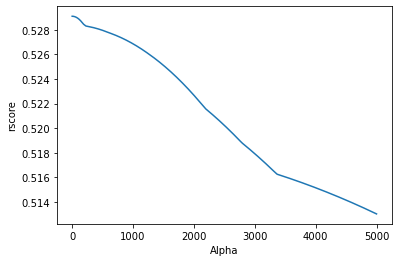

C:\Users\Ovie R. Iboyitie\AppData\Local\Temp\ipykernel_6336\176053780.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_reg.fit(X_train, y_train)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.468e+12, tolerance: 2.176e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_

0.5291090110116528


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.561e+12, tolerance: 2.988e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


<Figure size 432x288 with 0 Axes>

In [ ]:
lasso_reg = Lasso_Model(X_train, y_train)

In [ ]:
Lasso_model_test(X_test,y_test, lasso_reg)

0.6070950945279734
929731129.328676


,Features,lasso_reg_Weight_lower_salary,lasso_reg_Weight_upper_salary
0,contract_type,-8127.942047,-10060.444781
1,Machine Learning,0.000000,0.000000
2,SDLC,0.000000,0.000000
3,Python,0.000000,0.000000
4,Spark,0.000000,0.000000
5,client,0.000000,0.000000
6,Docker,0.000000,0.000000
7,Tableau,0.000000,0.000000
8,Vi,0.000000,0.000000
9,,0.000000,0.000000


### Saving the model for UK

In [ ]:
import pickle
filename = 'Lasso Model for UK.pkl'
pickle.dump(lasso_reg, open(filename, 'wb'))

In [ ]:
def Data_preprocessing(UK_IND_US_JOBS):
    # Reseting the index for UK_IND_US_JOBS
    UK_IND_US_JOBS.reset_index(drop=True, inplace = True)
    # Making a duplicate for UK_IND_US_JOBS
    UK_IND_US_JOBS_2 = UK_IND_US_JOBS.copy()
    # Preserving Position, Upper and lower salary columns by dropping them
    UK_IND_US_JOBS.drop(["upper_salary", "lower_salary", "Position"], axis="columns", inplace = True)

    # Fill the missing values for Years of experience using an iterative imputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute       import IterativeImputer
    #from catboost             import CatBoostRegressor

    imputer = IterativeImputer(
                                verbose   = 2,
                                max_iter  = 20,
                                imputation_order = 'descending' )


    UK_IND_US_JOBS = pd.DataFrame(imputer.fit_transform(UK_IND_US_JOBS), columns = UK_IND_US_JOBS.columns) # preserve the column nam

    # Restoring the Position, uppper and lower salary
    UK_IND_US_JOBS_2[list(UK_IND_US_JOBS.columns)] = UK_IND_US_JOBS

    # Defining a function that determines the Position based on years of expereience
    def Position_based_on_yoe(data):
        data.reset_index(drop=True, inplace = True)
        for i in range(data.shape[0]):
            if  data.loc[i,"Position"] is np.nan:
                if data.loc[i,"title scraped for"] == 0:
                    if  data.loc[i,"year_of_exp"] >= 3 and data.loc[i,"year_of_exp"] <= 5:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 5:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] < 3:
                        data.loc[i,"Position"] = "Entry Level"

                elif data.loc[i,"title scraped for"] == 1:
                    if  data.loc[i,"year_of_exp"] > 2 and data.loc[i,"year_of_exp"] <= 5:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 5:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] <= 2:
                        data.loc[i,"Position"] = "Entry Level"

                elif data.loc[i,"title scraped for"]== 2:
                    if  data.loc[i,"year_of_exp"] > 2 and data.loc[i,"year_of_exp"] <= 4:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 4:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] <= 2:
                        data.loc[i,"Position"] = "Entry Level"
                elif data.loc[i,"title scraped for"] == 3:
                    if  data.loc[i,"year_of_exp"] >= 3 and data.loc[i,"year_of_exp"] <= 5:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 5:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] < 3:
                        data.loc[i,"Position"] = "Entry Level"

                elif data.loc[i,"title scraped for"] == 4:
                    if  data.loc[i,"year_of_exp"] >= 2 and data.loc[i,"year_of_exp"] <= 4:
                            data.loc[i,"Position"] = "Mid-Level"
                    elif data.loc[i,"year_of_exp"] > 4:
                            data.loc[i,"Position"] = "Senior Level"
                    elif data.loc[i,"year_of_exp"] < 2:
                        data.loc[i,"Position"] = "Entry Level"

            else:
                data.loc[i,"Position"] = data.loc[i,"Position"]
        return data

    # Making a duplicate of the data
    data = UK_IND_US_JOBS_2.copy()
    # Filling the missing values for Position using the Position_based_on_yoe
    UK_IND_US_JOBS_3 = Position_based_on_yoe(data)

    number_of_observations(UK_IND_US_JOBS_3)

    # Encoding the Position column
    UK_IND_US_JOBS_3["Position"] = UK_IND_US_JOBS_3["Position"].astype('category')
    UK_IND_US_JOBS_3["Position"] = UK_IND_US_JOBS_3["Position"].cat.codes

    # Fill the missing values for upper salary using an iterative imputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute       import IterativeImputer
    #from catboost             import CatBoostRegressor

    imputer = IterativeImputer(
                                verbose   = 2,
                                max_iter  = 20,
                                imputation_order = 'descending' )


    df2 = pd.DataFrame(imputer.fit_transform(UK_IND_US_JOBS_3), columns = UK_IND_US_JOBS_3.columns) # preserve the column nam
    
    #df2 = UK_IND_US_JOBS_3.dropna(subset=["upper_salary"])
    # Extracting the features and target variable
    y = df2[["lower_salary", "upper_salary"]].values
    X = df2.drop(["lower_salary", "upper_salary"], axis="columns")
    XX = df2.drop(["lower_salary", "upper_salary"], axis="columns")


    # Normalizing the data
    #X= StandardScaler().fit(X).transform(X)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
    print ('Train set:', X_train.shape,  y_train.shape)
    print ('Test set:', X_test.shape,  y_test.shape)
    return XX, X_train, X_test, y_train, y_test

In [ ]:
# Selecting jobs for Nigeria, India and US
df1 = df.copy()
NIG_IND_US_JOBS = df1.query("Country != 2")
NIG_IND_US_JOBS.dropna(subset=["lower_salary"], inplace = True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[IterativeImputer] Completing matrix with shape (14443, 28)
[IterativeImputer] Ending imputation round 1/20, elapsed time 1.04
[IterativeImputer] Change: 1.5797534770123722, scaled tolerance: 0.025 
[IterativeImputer] Ending imputation round 2/20, elapsed time 1.92
[IterativeImputer] Change: 0.0, scaled tolerance: 0.025 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (14443, 31)
[IterativeImputer] Ending imputation round 1/20, elapsed time 1.04
[IterativeImputer] Change: 450125.51571716915, scaled tolerance: 450.0 
[IterativeImputer] Ending imputation round 2/20, elapsed time 1.97
[IterativeImputer] Change: 0.0, scaled tolerance: 450.0 
[IterativeImputer] Early stopping criterion reached.
Train set: (11554, 29) (11554, 2)
Test set: (2889, 29) (2889, 2)


C:\Users\Ovie R. Iboyitie\AppData\Local\Temp\ipykernel_6336\176053780.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_reg.fit(X_train, y_train)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e+12, tolerance: 2.273e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_d

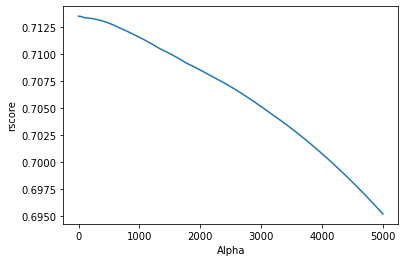

C:\Users\Ovie R. Iboyitie\AppData\Local\Temp\ipykernel_6336\176053780.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_reg.fit(X_train, y_train)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


0.7134891020314018


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e+12, tolerance: 2.273e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.294e+12, tolerance: 3.631e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

<Figure size 432x288 with 0 Axes>

In [ ]:
XX, X_train, X_test, y_train, y_test = Data_preprocessing(NIG_IND_US_JOBS)
lasso_reg = Lasso_Model(X_train, y_train)

In [ ]:
for feature in categorical_columns:
    print(X_train[feature].value_counts())

4.0    3499
0.0    2489
2.0    2045
1.0    1939
3.0    1582
Name: title scraped for, dtype: int64
1.0    4007
0.0    3963
3.0    3584
Name: Country, dtype: int64
1.0    5979
0.0    2832
2.0    2743
Name: Position, dtype: int64
1.0    11181
0.0      373
Name: contract_type, dtype: int64
1.0    6016
0.0    4063
2.0    1418
3.0      57
Name: eligibility, dtype: int64


In [ ]:
Lasso_model_test(X_test,y_test, lasso_reg)

0.7273198361859552
645284416.3710217


,Features,lasso_reg_Weight_lower_salary,lasso_reg_Weight_upper_salary
0,contract_type,-2947.186977,-2999.083314
1,Machine Learning,0.000000,0.000000
2,SDLC,0.000000,0.000000
3,Python,0.000000,0.000000
4,Spark,0.000000,0.000000
5,client,0.000000,0.000000
6,Docker,0.000000,0.000000
7,Tableau,0.000000,0.000000
8,Vi,0.000000,0.000000
9,,0.000000,0.000000


### Saving the model for Nigeria, US and India

In [ ]:
import pickle
filename = 'Lasso Model for US NIG and IND.pkl'
pickle.dump(lasso_reg, open(filename, 'wb'))